In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

class FLUser:
    def __init__(self, user_id):
        self.id = user_id
        self.reputation = 500.0       # 初始声誉 (0-1000)
        self.stake_history = []       # 质押记录
        self.reward_history = []      # 奖励记录
        self.cost_history = []        # 总成本记录
        self.utility_history = []     # 效用记录
        self.participation_prob = 0.8 # 参与概率基准值
        self.strategy = "honest"      # 参与策略 [honest, lazy, aggressive]
        
    def calculate_utility(self, params):
        """计算单轮效用"""
        # 获取最新数据
        last_reward = self.reward_history[-1] if self.reward_history else 0
        last_stake = self.stake_history[-1] if self.stake_history else 0
        last_cost = self.cost_history[-1] if self.cost_history else 0
        
        # 声誉增益（相比上轮）
        rep_gain = self.reputation - (self.utility_history[-1]["reputation"] 
                    if self.utility_history else 500)
        
        # 计算净收益
        net_income = last_reward + last_stake * (1 - params["slashing_rate"]) - last_cost
        
        # 效用计算
        utility = net_income + params["lambda"] * rep_gain
        
        # 记录详细数据
        self.utility_history.append({
            "round": len(self.utility_history)+1,
            "net_income": net_income,
            "rep_gain": rep_gain,
            "total_utility": utility,
            "reputation": self.reputation
        })
        return utility

class FLSimulator:
    def __init__(self, num_users=100, rounds=20):
        self.users = [FLUser(i) for i in range(num_users)]
        self.rounds = rounds
        self.params = {
            "base_stake": 1.0,        # 基础质押 (ETH)
            "stake_fee_rate": 0.02,   # 质押费率
            "compute_cost": 0.1,      # 基础计算成本 (ETH)
            "lambda": 0.2,            # 声誉转化系数
            "slashing_rate": 0.05,    # 惩罚扣除比例
            "reward_multiplier": 1.2  # 奖励乘数
        }
        self.system_metrics = []
        
    def _simulate_round(self, round_num):
        # 阶段1：用户决策是否参与
        participants = []
        for user in self.users:
            # 策略影响参与概率
            if user.strategy == "lazy":
                prob = user.participation_prob * 0.6
            else:
                prob = user.participation_prob
                
            if np.random.random() < prob:
                participants.append(user)
        
        # 阶段2：动态质押计算
        total_stakes = 0
        for user in participants:
            # 基于声誉的质押计算
            stake = self.params["base_stake"] * (1 - user.reputation/2000)
            stake_with_fee = stake * (1 + self.params["stake_fee_rate"])
            user.stake_history.append(stake_with_fee)
            total_stakes += stake_with_fee
            
            # 记录质押成本
            user.cost_history.append(stake_with_fee)
        
        # 阶段3：模型训练与奖励分配
        total_rewards = total_stakes * self.params["reward_multiplier"]
        rewards = self._allocate_rewards(participants, total_rewards)
        
        # 阶段4：更新声誉和效用
        for i, user in enumerate(participants):
            # 模拟模型质量（受策略影响）
            if user.strategy == "honest":
                quality = np.random.beta(user.reputation/500, 2)
            elif user.strategy == "lazy":
                quality = np.random.beta(0.5, 2)
            else:  # aggressive
                quality = np.random.beta(2, 0.5)
            
            # 声誉更新
            rep_change = 50 * (quality - 0.6)  # 质量阈值0.6
            user.reputation = np.clip(user.reputation + rep_change, 0, 1000)
            
            # 计算成本（与模型复杂度正相关）
            compute_cost = self.params["compute_cost"] * (1 + quality**2)
            user.cost_history[-1] += compute_cost
            
            # 分配奖励
            user.reward_history.append(rewards[i])
            
            # 计算效用
            user.calculate_utility(self.params)
        
        # 收集系统指标
        self.system_metrics.append({
            "round": round_num+1,
            "participants": len(participants),
            "avg_utility": np.mean([u.utility_history[-1]["total_utility"] 
                                   for u in participants if u.utility_history]),
            "total_stakes": total_stakes,
            "total_rewards": total_rewards
        })
    
    def _allocate_rewards(self, participants, total_rewards):
        # 基于声誉的奖励分配
        reputations = [u.reputation for u in participants]
        total_rep = sum(reputations)
        return [total_rewards * (r/total_rep) for r in reputations]
    
    def run_simulation(self):
        for round in range(self.rounds):
            self._simulate_round(round)
        return pd.DataFrame(self.system_metrics)

# 初始化模拟器并运行
R = 20
U = 5
simulator = FLSimulator(num_users=U, rounds=R)
# simulator = FLSimulator(num_users=100, rounds=20)
results = simulator.run_simulation()

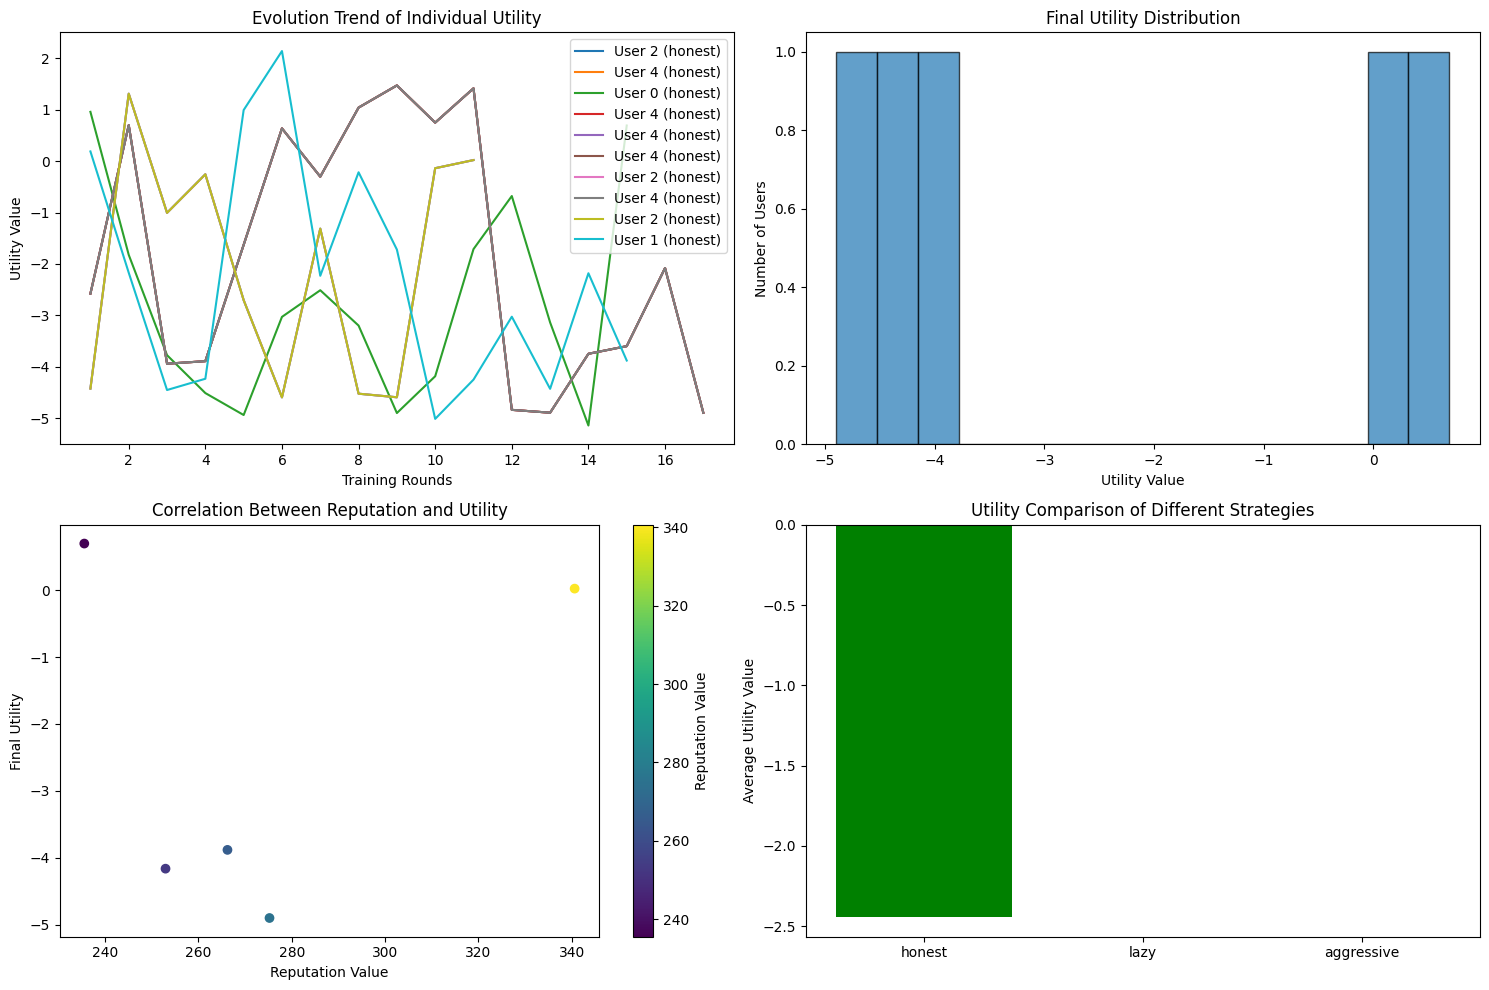

In [2]:
plt.figure(figsize=(15, 10))

# 效用趋势分析
plt.subplot(2, 2, 1)
sample_users = np.random.choice(simulator.users, 10)
print(sample_users)
for i, user in enumerate(sample_users):
    utilities = [u["total_utility"] for u in user.utility_history]
    plt.plot(range(1, len(utilities)+1), utilities, 
             label=f'User {user.id} ({user.strategy})')
# plt.title('个体效用演化趋势')
# plt.xlabel('训练轮次')
# plt.ylabel('效用值')
plt.title('Evolution Trend of Individual Utility')
plt.xlabel('Training Rounds')
plt.ylabel('Utility Value')

plt.legend()

# 系统级效用分布
plt.subplot(2, 2, 2)
final_utilities = [u.utility_history[-1]["total_utility"] 
                   for u in simulator.users if u.utility_history]
plt.hist(final_utilities, bins=15, edgecolor='k', alpha=0.7)
# plt.title('最终效用分布')
# plt.xlabel('效用值')
# plt.ylabel('用户数量')
plt.title('Final Utility Distribution')
plt.xlabel('Utility Value')
plt.ylabel('Number of Users')



# 声誉与效用相关性
plt.subplot(2, 2, 3)
reputations = [u.reputation for u in simulator.users]
plt.scatter(reputations, final_utilities, c=reputations, cmap='viridis')
# plt.colorbar(label='声誉值')
# plt.title('声誉-效用相关性')
# plt.xlabel('声誉值')
# plt.ylabel('最终效用')
plt.colorbar(label='Reputation Value')
plt.title('Correlation Between Reputation and Utility')
plt.xlabel('Reputation Value')
plt.ylabel('Final Utility')


# 参与策略对比
plt.subplot(2, 2, 4)
strategies = ['honest', 'lazy', 'aggressive']
avg_utils = []
for strat in strategies:
    users = [u for u in simulator.users if u.strategy == strat]
    utils = [u.utility_history[-1]["total_utility"] for u in users if u.utility_history]
    avg_utils.append(np.mean(utils) if utils else 0)
plt.bar(strategies, avg_utils, color=['green', 'red', 'blue'])
# plt.title('不同策略的效用对比')
# plt.ylabel('平均效用值')
plt.title('Utility Comparison of Different Strategies')
plt.ylabel('Average Utility Value')


plt.tight_layout()
plt.show()